# CAB420, Neural Attention, Example 1: Attention and RNNs
Dr Simon Denman (s.denman@qut.edu.au)

# Overview

The idea of attention is to learn which parts of the input (or of some internal representation) are most relevant, and to try to direct the network towards these parts. There are very many different variations on attention, but the general approach can be summarised as:
* Learn an additional layer that will consider the importance of locations within an input
* Use this learned importance to weight the input/representation such that more important regions are more prominent

Attention actually first emerged in text processing, and this example will quickly explore how we can use a simple attention layer within an LSTM network for classifying tweets.

## Too Long; Didn't Read:
* Attention is effectively an additional layer, learned with the rest of the network. While we can hand-craft attention rules, this is generally less desireable as it requires us to make assumptions on what is important in the data, rather than learn directly from the data
* We can set attention up in many different ways, for example we:
  * can consider each location independantly
  * can weight locations based on the relationship between the location itself and all other locations
  * can vary the activations used to be more or less selective (i.e. select more or fewer regions as being important)
  * can use one input/representation to direct attention for a different input/representation (note, this is not shown in this example)
* We can use attention in multiple locations within a network
* Depending on the formulation, attention is something that is fairly easy to visualise, and can help us understand what the network is doing (or at least, what a small part of the network is doing)
* Provided we are not too selective with what information we allow to flow through, attention will generally improve performance
  * If we get too selective, we can reduce information flow too much. In such cases not enough information will reach later layers, and this will hamper (or even prevent) learning

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pandas
import numpy
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.utils import model_to_dot, plot_model
import seaborn

## The Data
Still twitter data. Same setup as last time - though we're taking a few more samples as we're training a NN.

In [2]:
tweets = pandas.read_csv('../data/sentiment140/training.1600000.processed.noemoticon.csv')
print(tweets.head())

tweet_text = tweets.iloc[:, -1].tolist()
Y = numpy.array(tweets.iloc[:, 0])
Y[Y > 0] = 1

num_samples = 60000
train_samples = 50000
samples = numpy.random.choice(len(Y), num_samples)

train_X = [tweet_text[i] for i in samples[0:train_samples]]
train_Y = Y[samples[0:train_samples]]
test_X = [tweet_text[i] for i in samples[train_samples:]]
test_Y = Y[samples[train_samples:]]
print(numpy.shape(train_X))
print(numpy.shape(train_Y))
print(numpy.shape(test_X))
print(numpy.shape(test_Y))

   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....           

### Data Preperation

This is as per our examples on sequences. 

We need to get our data into something numeric. Previously when we've played with text data, this has meant:
* text embeddings
* bag of words

We'll use an embedding again, but rather than use gensim and train one there, we'll build one as part of our network (i.e. we'll let Keras do it). To do that, we need to tokensize our document, and build it into sequences of the same length by padding the sequences.

Note that we could train our network with variable length sequences. However it does require a lot more effort to set up, and would distract from the main part of this example.

In [3]:
max_words = 50000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_X)

In [4]:
train_sequences = []
for seq in tokenizer.texts_to_sequences_generator(train_X):
    train_sequences.append(seq)

test_sequences = []
for seq in tokenizer.texts_to_sequences_generator(test_X):
    test_sequences.append(seq)
    
def find_max_list(list):
    list_len = [len(i) for i in list]
    return (max(list_len))

max_length = max(find_max_list(train_sequences), find_max_list(test_sequences))

train_padded_X = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded_X = pad_sequences(test_sequences, maxlen=max_length, padding='post')

## A Recurrent Neural Network

We'll start by setting up a baseline network to compare to. This will be very similar to our earlier LSTM based networks. We'll use two LSTMs. The first will be a sequence-to-sequence LSTM, the second of will just output a single vector and we can classify that directly. Our attention will sit between the two LSTMs.

In [5]:
inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(max_words, 128, input_length=max_length)(inputs)
x = layers.LSTM(64, return_sequences=True, return_state=False)(x)
x = layers.LSTM(64, return_sequences=False, return_state=False)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.summary()

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         6400000   
                                                                 
 lstm (LSTM)                 (None, None, 64)          49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 6,482,497
Trainable params: 6,482,497
Non-trainable params: 0
_________________________________________________________________


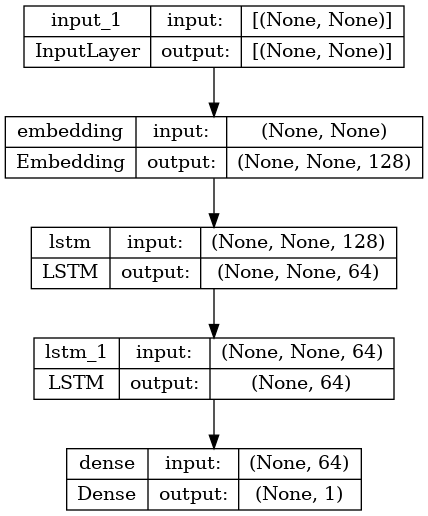

In [6]:
plot_model(model, show_shapes=True)

In [7]:
batch_size = 128
epochs = 5

model.fit(train_padded_X, train_Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(test_padded_X, test_Y))

Epoch 1/5
391/391 [==============================] - 10s 17ms/step - loss: 0.5240 - accuracy: 0.7293 - val_loss: 0.4672 - val_accuracy: 0.7770
Epoch 2/5
391/391 [==============================] - 6s 15ms/step - loss: 0.3640 - accuracy: 0.8438 - val_loss: 0.4933 - val_accuracy: 0.7713
Epoch 3/5
391/391 [==============================] - 6s 15ms/step - loss: 0.2554 - accuracy: 0.8966 - val_loss: 0.5874 - val_accuracy: 0.7569
Epoch 4/5
391/391 [==============================] - 6s 14ms/step - loss: 0.1787 - accuracy: 0.9289 - val_loss: 0.6734 - val_accuracy: 0.7471
Epoch 5/5
391/391 [==============================] - 6s 15ms/step - loss: 0.1277 - accuracy: 0.9521 - val_loss: 0.7620 - val_accuracy: 0.7504


Now we can evaluate the model, and we see that it works pretty well.

Test loss: 0.7619879841804504
Test accuracy: 0.7504000067710876


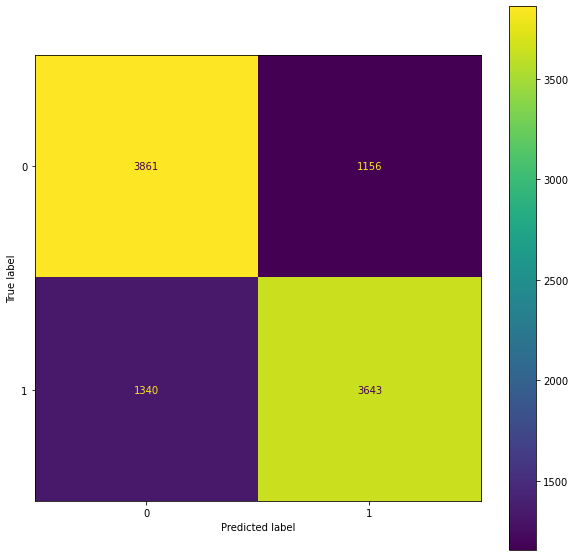

In [8]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=False)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test, verbose=False);
    pred = pred >= 0.5
    
    cm = confusion_matrix(y_test, pred)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)

eval_model(model, test_padded_X, test_Y)

## Adding Attention

Attention mechanisms come in many, many, variations. We'll keep it fairly simple here, but if you want to see a few more options go check out ``CAB420_Neural_Attention_Bonus_Example_Attention_and_DCNNs.ipynb``. 

First up, we'll create a model that aims to assess each word, and decide how important that word is for our task (sentiment classification). As such, we'll add a layer to analyse a word and ouptut a single value indicating importance. We can then get those values for each word, standardise them in some way, and multiply them by the original embedding.

In [9]:
inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(max_words, 128, input_length=max_length)(inputs)
x = layers.LSTM(64, return_sequences=True, return_state=False)(x)

# attention mechanism starts here
# This layer will look at each word, and output a single value to indicate it's importance
e = layers.Dense(1, activation='tanh')(x)
# flatter the word level importance
e = layers.Flatten()(e)
# apply a softmax to the word importance vectors
a = layers.Activation('softmax', name='attention')(e)
# we need to now multiply the word importance vector by the input to our attention process, x
# x is of shape [64, num_words], so we need 64 copies of our attention vector
temp = layers.RepeatVector(64)(a)
# get the dimensions in the correct order
temp = layers.Permute([2, 1])(temp)
# multiply our input by our attention vector
x = layers.Multiply()([x, temp])
# continue on with the network

x = layers.LSTM(64, return_sequences=False, return_state=False)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.summary()

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 128)    6400000     ['input_2[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (None, None, 64)     49408       ['embedding_1[0][0]']            
                                                                                                  
 dense_1 (Dense)                (None, None, 1)      65          ['lstm_2[0][0]']                 
                                                                                            

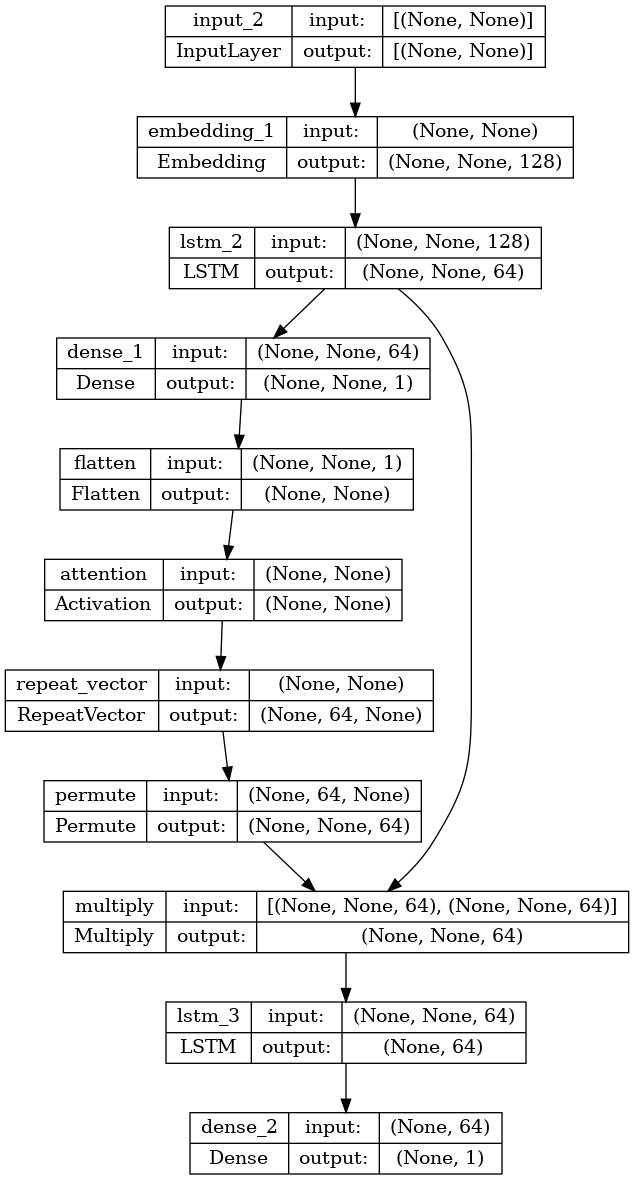

In [10]:
plot_model(model, show_shapes=True)

The trickest part of our attention mechanism is (I think) the repeat and reshape bit. Let's break down the layers one by one:
* the input to our attention block (lstm_2) has shape (None, None, 64), which means (batch_size, sequence_length, 64). What we want to do is learn some mask to apply to this representation that emphasises important things. Thus, we need to end up with a mask that's also (batch_size, sequence_length, 64).
* dense_1 takes our representation from (batch_size, sequence_length, 64) to (batch_size, sequence_length, 1), we're getting a single value to capture the importance of each word. This really is the attention score right here.
* flatten_1 drops the last dimension, so we now have (batch_size, sequence_length) as our representation. This is critical for the next layer to work properly.
* activation is next, and here we're using softmax. What we want to do is run the softmax over each sequence, so the attention scores for each sequence sum to 1. If we didn't have the above flatten, our softmax would be applied to each (batch_size, sequence_length, 1) cell, which would just mean that every attention score would be. By using the above flatten, we get a shape that will allow us to run the softmax across the sequence, normalising the important words. At this point we have our normalised attention scores, so we need to get back from a (batch_size, sequence_length) shape to (batch_size, sequence_length, 64) so we can combine the attention scores with the input. All we want to do is stack 64 of these (batch_size, sequence_length) things, such that the size 64 embedding for each word is multiplied by a constant weight
* repeat_vector does the first part of what we need, repeating the vector 64 times, but it puts things in the wrong order, giving us (batch_size, 64, sequence_length) rather than (batch_size, sequence_length, 64)
* permute finishes the job, swapping the last two dimensions to get a (batch_size, sequence_length, 64) representation
* Finally, we have the multiply layer, that simply multiplies the data representation by the attention scores.

There are a lot of things we can change about this. For example:
* We could use a different activation for our attention scores, such as a sigmoid
* We could use addition rather than multiplication to combine our attention scores with our representation
* We could compute the attention scores in a different way

We could also wrap all of the operations up in a single layer, rather than the combination we've used above.

In [11]:
model.fit(train_padded_X, train_Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(test_padded_X, test_Y))

Epoch 1/5
391/391 [==============================] - 10s 19ms/step - loss: 0.5547 - accuracy: 0.6989 - val_loss: 0.4951 - val_accuracy: 0.7657
Epoch 2/5
391/391 [==============================] - 7s 17ms/step - loss: 0.3782 - accuracy: 0.8363 - val_loss: 0.4939 - val_accuracy: 0.7668
Epoch 3/5
391/391 [==============================] - 7s 18ms/step - loss: 0.2644 - accuracy: 0.8940 - val_loss: 0.5884 - val_accuracy: 0.7677
Epoch 4/5
391/391 [==============================] - 7s 17ms/step - loss: 0.1767 - accuracy: 0.9310 - val_loss: 0.7128 - val_accuracy: 0.7555
Epoch 5/5
391/391 [==============================] - 7s 17ms/step - loss: 0.1294 - accuracy: 0.9508 - val_loss: 0.7513 - val_accuracy: 0.7572


Test loss: 0.751305103302002
Test accuracy: 0.7572000026702881


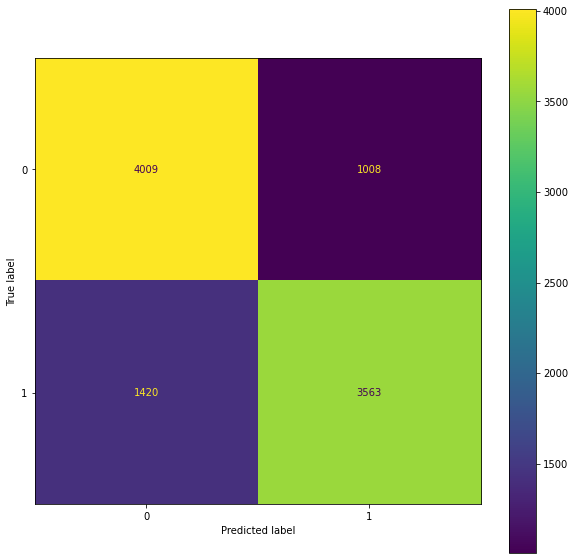

In [12]:
eval_model(model, test_padded_X, test_Y)

Our model works ok. We're not getting a huge change here, as we're already somewhat up against the limit with this data, and the fact that our sequences are small means that the LSTMs were able to do a fairly good job of keeping track of what was in the sequence already (for more dramatic results, see ``CAB420_Neural_Attention_Bonus_Example_Attention_and_DCNNs.ipynb``).

### Visualising Attention

One nice thing that we can now do though is visualise the attention scores. We can pull this result out of the network, and essentially see what the network thinks is important.

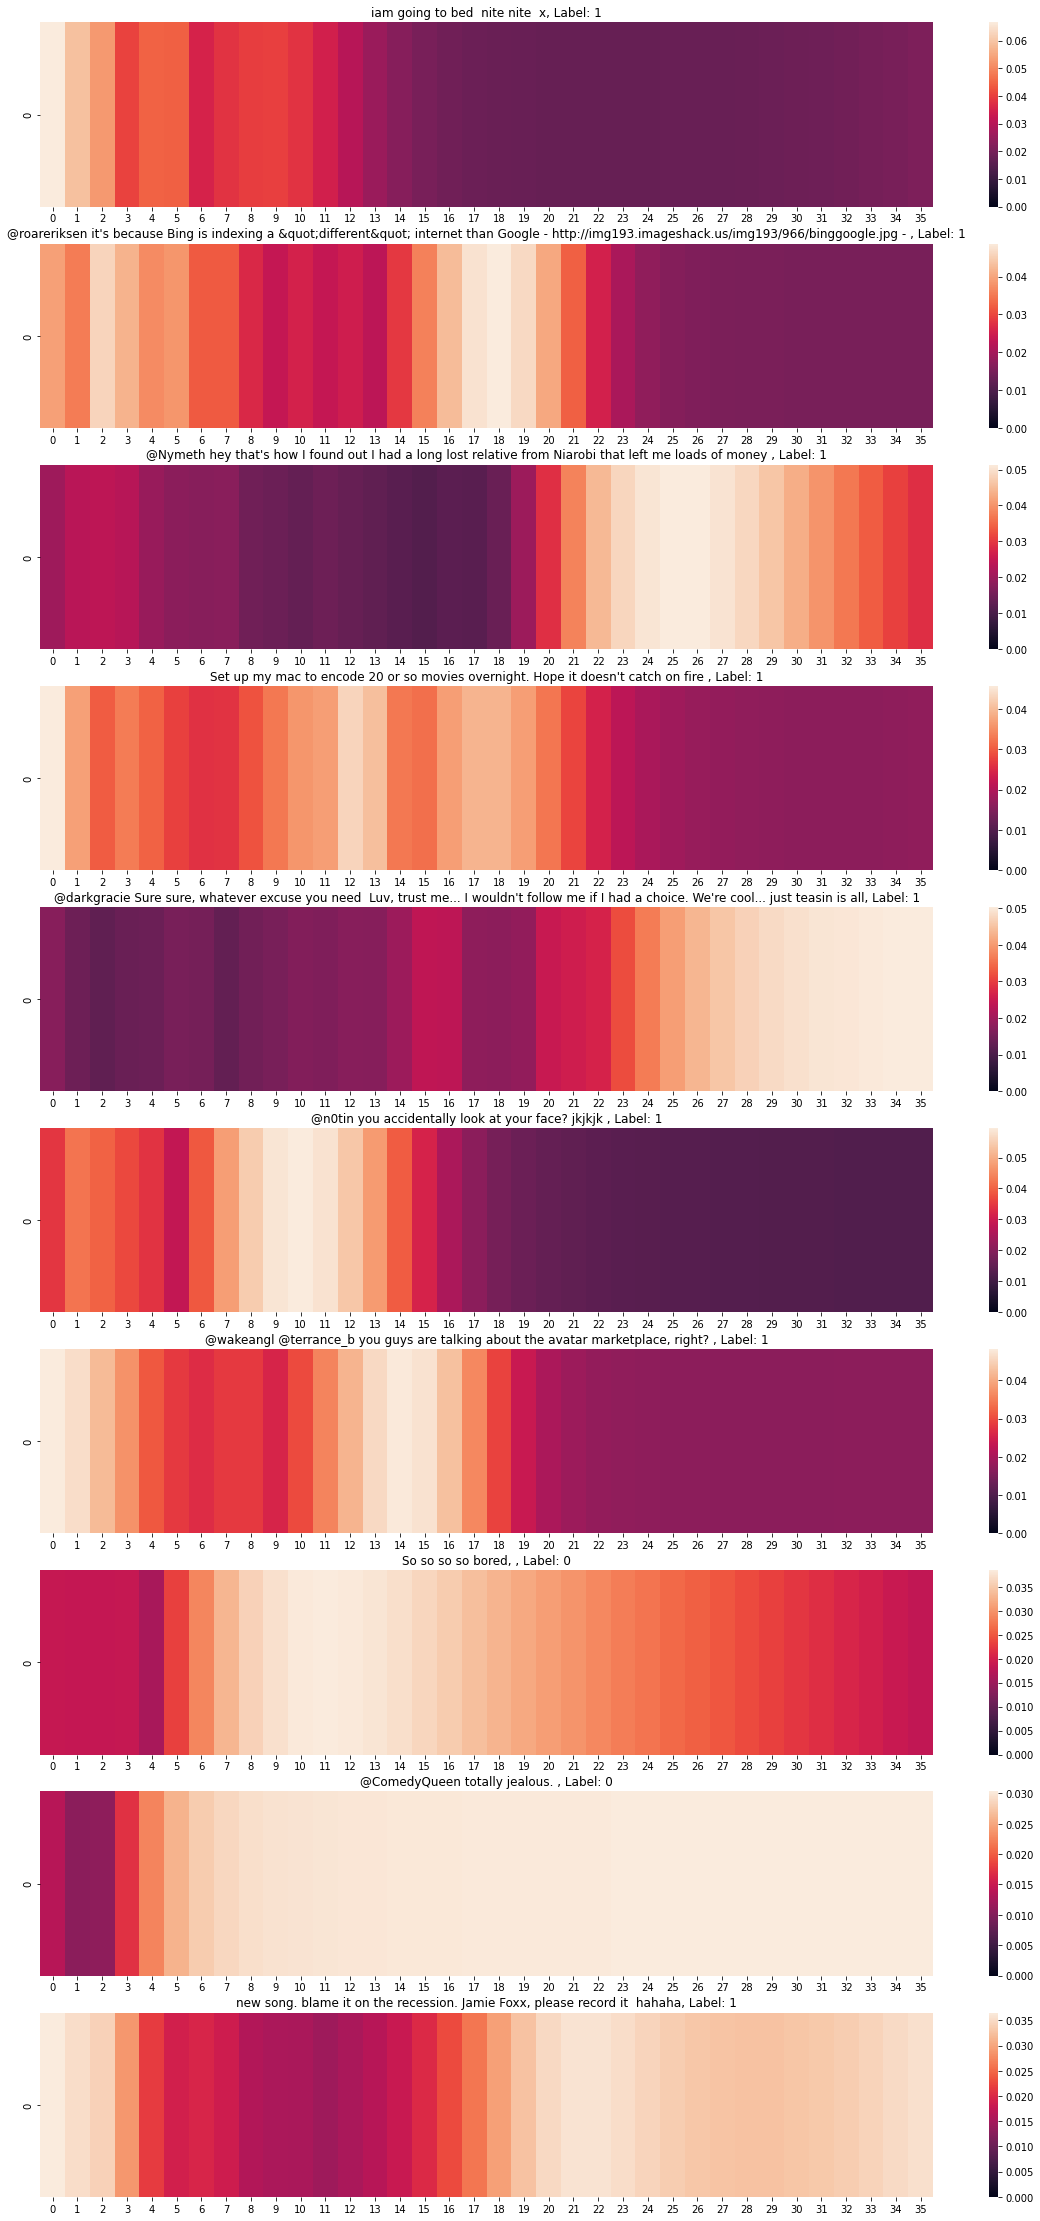

In [13]:
layer_name = 'attention'
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)

def visualise_attention(intermediate_layer_model, test_padded_X, test_X, test_Y, start_pos):
    fig = plt.figure(figsize=[20, 40])
    for i in range(10):
        intermediate_output = numpy.array(intermediate_layer_model(test_padded_X[i+start_pos:i+start_pos+1,:]))
        ax = fig.add_subplot(10, 1, i+1)
        seaborn.heatmap(intermediate_output,vmin=0)
        ax.set_title(test_X[i+start_pos] + ', Label: ' + str(test_Y[i+start_pos]))
        
visualise_attention(intermediate_layer_model, test_padded_X, test_X, test_Y, 42)

From the above, we see that what's important varies across the tweets - which is good. This is what we'd expect as not all tweats are equal, and the key words and their placement with respect to sentiment will vary. 

One thing that is perhaps most interesting here is the behaviour at the end of the sequence, where we're looking at embeddings that (losely) correspond to empty embeddings that have been used to pad the sequence. We see that in some cases we have embeddings that are highly weighted, others have low weights, but they are often quite uniform. 

It's important to note here that each "slot" in our attention vector does not correspond to a word exactly, rather it corresponds to the output of the LSTM up to that point in the sequence. So the fourth slot is the embedding that arises after the fourth word is processed, and thus depends on the first four words. Perhaps with that in mind, it's better to think of these are showing important "parts" of the input rather than specific words. A large step change in importance indicates that we've suddenly seen a word that's particularly important (or un-important) in the context of the tweet.

### Sigmoid rather than Softmax

For science, we'll now change our softmax activation to a sigmoid. This should allow a little more information to flow, but will also do less in terms of identifying the most important word or two in the tweet.

This really is very similar to our first network, with just a change to the activations.

In [14]:
inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(max_words, 128, input_length=max_length)(inputs)
x = layers.LSTM(64, return_sequences=True, return_state=False)(x)

# attention mechanism starts here
# again we have a dense layer to look at individual words, but we now have a sigmoid here
e = layers.Dense(1, activation='sigmoid')(x)
# now starts the shape manipulation. We need to weight each word in the original embedding (x)
# by the attention weight, so do to this we will do a flatten, repeat the vector 64 times (size
# of the embedding), and finally adjust the dimensions
a = layers.Flatten(name='attention')(e)
temp = layers.RepeatVector(64)(a)
temp = layers.Permute([2, 1])(temp)
# now we can multiply our attention weight by the input vector
x = layers.Multiply()([x, temp])
# and we can use the augmented embedding in the rest of the network

x = layers.LSTM(64, return_sequences=False, return_state=False)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.summary()

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 128)    6400000     ['input_3[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  (None, None, 64)     49408       ['embedding_2[0][0]']            
                                                                                                  
 dense_3 (Dense)                (None, None, 1)      65          ['lstm_4[0][0]']                 
                                                                                            

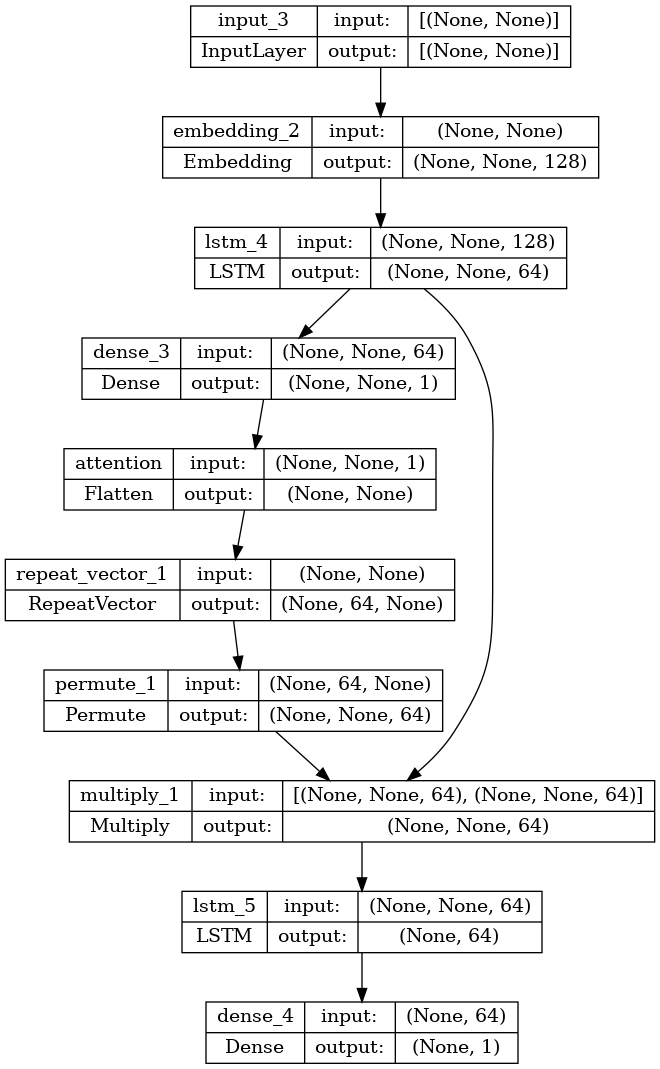

In [15]:
plot_model(model, show_shapes=True)

In [16]:
model.fit(train_padded_X, train_Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(test_padded_X, test_Y))

Epoch 1/5
391/391 [==============================] - 10s 18ms/step - loss: 0.5276 - accuracy: 0.7291 - val_loss: 0.4704 - val_accuracy: 0.7770
Epoch 2/5
391/391 [==============================] - 6s 16ms/step - loss: 0.3621 - accuracy: 0.8457 - val_loss: 0.5288 - val_accuracy: 0.7644
Epoch 3/5
391/391 [==============================] - 6s 17ms/step - loss: 0.2586 - accuracy: 0.8956 - val_loss: 0.5779 - val_accuracy: 0.7609
Epoch 4/5
391/391 [==============================] - 7s 17ms/step - loss: 0.1889 - accuracy: 0.9255 - val_loss: 0.6979 - val_accuracy: 0.7514
Epoch 5/5
391/391 [==============================] - 7s 17ms/step - loss: 0.1415 - accuracy: 0.9436 - val_loss: 0.7820 - val_accuracy: 0.7555


Test loss: 0.7819875478744507
Test accuracy: 0.7555000185966492


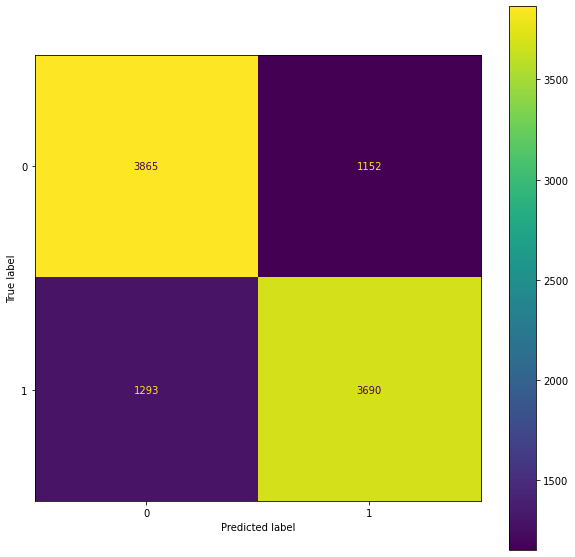

In [17]:
eval_model(model, test_padded_X, test_Y)

Performance wise, we're at about the same point as before.

Let's visualise some activations now.

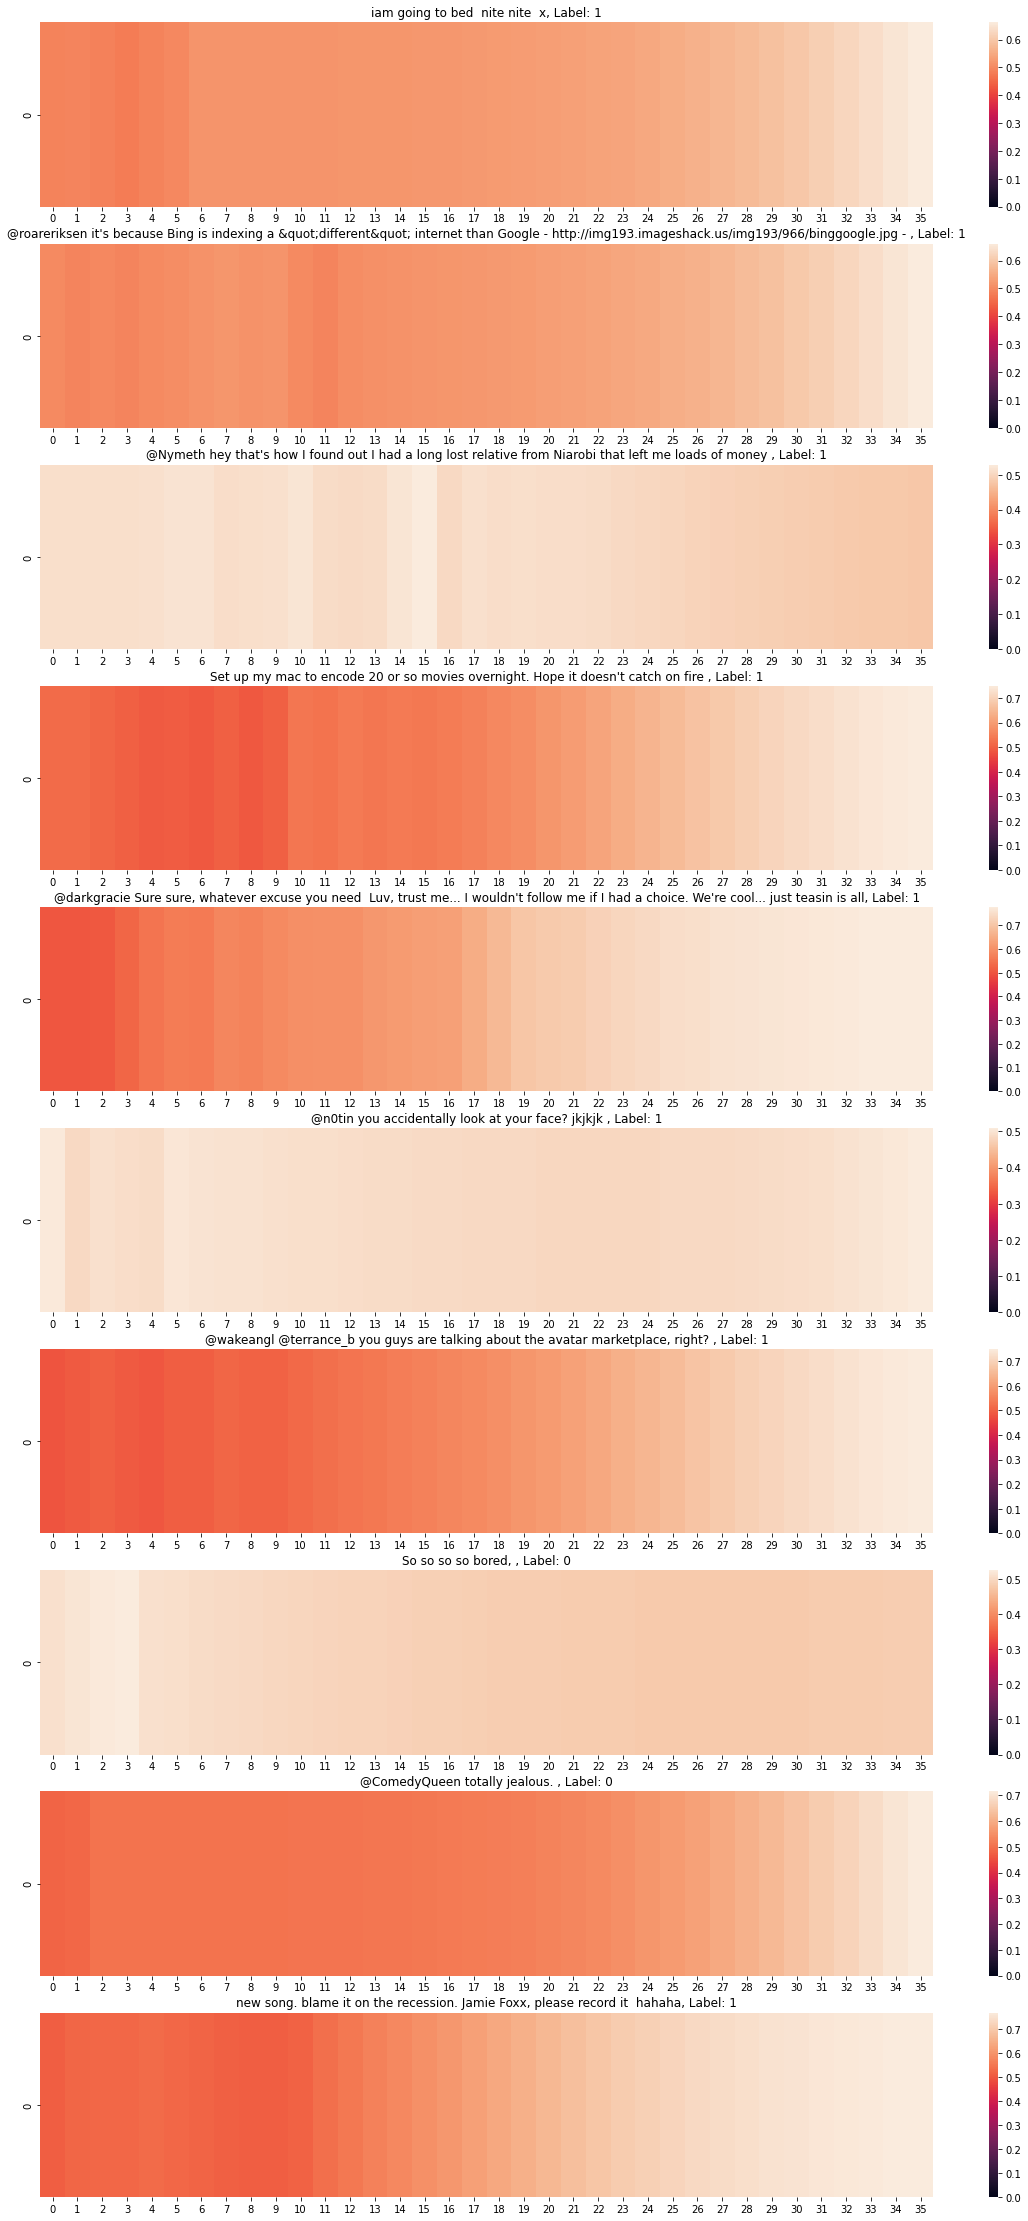

In [18]:
layer_name = 'attention'
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
        
visualise_attention(intermediate_layer_model, test_padded_X, test_X, test_Y, 42)

We can see similar patterns of behaviour here to what we saw with our softmax output. In this case, we're perhaps seeing a greater distributions of values than in our softmax version, i.e. there is more variation in the weights that are seeing.

## Final Thoughts

In this example, we've looked at a simple way to incorporate attention into a recurrent network, and applied this to our twitter data. 

In this case it hasn't resulted in any major performance gain, which we can attribute to:
* Our non-attention network already doing well
* The tweets being fairly short, thus being modelled quite well by the LSTM
* The ambiguity in the data making higher performance tricky

Longer sequences will lead to larger benefits, though even with these small sequences the ability to visualise the attention and help understand what is being focussed on is valuable. We should also note that for simplicity, we've not looked at using a bi-directional network here, though again we could add this and use attention which may help improve performance a little bit more.